In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import gym

[2017-03-28 12:22:41,438] You have 'numpy' version 1.10.1 installed, but 'gym' requires at least 1.10.4. HINT: upgrade via 'pip install -U numpy'.


In [5]:
import theano
from theano import tensor as T
import lasagne
from lasagne.layers import *
from lasagne.objectives import *
from lasagne.nonlinearities import *
from lasagne.updates import *
import gym
import numpy as np
from skimage.color import rgb2gray
from skimage.transform import resize
import cPickle as pickle
import itertools
from collections import deque

In [6]:
def dqn_paper_net(env, args={}):
    def batch_norm_or_not(layer, bn):
        if bn:
            return batch_norm(layer)
        else:
            return layer
    nonlinearity = rectify if "nonlinearity" not in args else args["nonlinearity"]
    bn = True if "batch_norm" in args else False
    #height, width, nchannels = env.observation_space.shape
    height, width = 80, 80
    nchannels = 4 # we convert to black and white and use 4 prev frames
    layer = InputLayer((None, nchannels, height, width))
    layer = batch_norm_or_not(Conv2DLayer(layer, filter_size=8, num_filters=16, stride=4, nonlinearity=nonlinearity), bn)
    layer = batch_norm_or_not(Conv2DLayer(layer, filter_size=4, num_filters=32, stride=2, nonlinearity=nonlinearity), bn)
    layer = batch_norm_or_not(DenseLayer(layer, num_units=256, nonlinearity=nonlinearity), bn)
    layer = DenseLayer(layer, num_units=env.action_space.n, nonlinearity=linear)
    return layer

In [7]:
def preprocessor_pong(img):
    img = rgb2gray(img) # (210, 160)
    img = resize(img, (img.shape[0]//2, img.shape[1]//2)) # (105, 80)
    img = img[17:97,:] # (80, 80)
    return img

In [8]:
env = gym.make('Pong-v0')

[2017-03-28 12:22:45,583] Making new env: Pong-v0


In [101]:
for layer in get_all_layers(dqn_paper_net(env)):
    print layer, layer.output_shape

<lasagne.layers.input.InputLayer object at 0x116865090> (None, 4, 80, 80)
<lasagne.layers.conv.Conv2DLayer object at 0x116865190> (None, 16, 19, 19)
<lasagne.layers.conv.Conv2DLayer object at 0x116865350> (None, 32, 8, 8)
<lasagne.layers.dense.DenseLayer object at 0x116865650> (None, 256)
<lasagne.layers.dense.DenseLayer object at 0x116865890> (None, 6)


----

In [9]:
from collections import deque

In [78]:
phi_t = None
debug_t = None
buf_maxlen = 4
buf = deque(maxlen=buf_maxlen*4)
env.reset()
r_j = 0.
experience = []
a_t = env.action_space.sample()
ctr = 0
for t in itertools.count():
    if t % buf_maxlen == 0:
        a_t = env.action_space.sample()
    else:
        a_t = a_t
    # execute action a_t in emulator and observe
    # reward r_t and image x_t+1
    x_t1, r_t, is_done, info = env.step(a_t)
    buf.append({'x_t1':x_t1, 'r_t':r_t, 'a_t':a_t, 't':t})

    if len(buf) == buf_maxlen*4:
        ctr += 1
        #if ctr == 2:
        #    break
        phi_t1 = np.asarray([ buf[0]['x_t1'], buf[4]['x_t1'], buf[8]['x_t1'], buf[12]['x_t1'] ], dtype="float32")
        debug_t1 = [buf[0]['t'], buf[4]['t'], buf[8]['t'], buf[12]['t']]
        if phi_t != None:
            print debug_t, debug_t1
            if is_done:
                tp = {"phi_t":phi_t, "r_t":np.sum([ elem['r_t'] for elem in list(buf) ]), "a_t":list(buf)[-1]['a_t'], "phi_t1":phi_t, "is_done":is_done, "debug_t":debug_t, "debug_t1":debug_t1}
            else:
                tp = {"phi_t":phi_t, "a_t":a_j, "r_t":r_j, "phi_t1":phi_t1, "is_done":is_done, "debug_t":debug_t, "debug_t1":debug_t1}
            #self._check_tp(tp)
            experience.append(tp)
        #print [ debug_buf[0], debug_buf[4], debug_buf[8], debug_buf[12] ]
        if is_done:
            break
        phi_t = phi_t1
        debug_t = debug_t1
        r_j = np.sum([ buf[-1]['r_t'], buf[-2]['r_t'], buf[-3]['r_t'], buf[-4]['r_t'] ])
        a_j = list(buf)[-1]['a_t']
        for i in range(4):
            buf.popleft()


/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:26: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


[0, 4, 8, 12] [4, 8, 12, 16]
[4, 8, 12, 16] [8, 12, 16, 20]
[8, 12, 16, 20] [12, 16, 20, 24]
[12, 16, 20, 24] [16, 20, 24, 28]
[16, 20, 24, 28] [20, 24, 28, 32]
[20, 24, 28, 32] [24, 28, 32, 36]
[24, 28, 32, 36] [28, 32, 36, 40]
[28, 32, 36, 40] [32, 36, 40, 44]
[32, 36, 40, 44] [36, 40, 44, 48]
[36, 40, 44, 48] [40, 44, 48, 52]
[40, 44, 48, 52] [44, 48, 52, 56]
[44, 48, 52, 56] [48, 52, 56, 60]
[48, 52, 56, 60] [52, 56, 60, 64]
[52, 56, 60, 64] [56, 60, 64, 68]
[56, 60, 64, 68] [60, 64, 68, 72]
[60, 64, 68, 72] [64, 68, 72, 76]
[64, 68, 72, 76] [68, 72, 76, 80]
[68, 72, 76, 80] [72, 76, 80, 84]
[72, 76, 80, 84] [76, 80, 84, 88]
[76, 80, 84, 88] [80, 84, 88, 92]
[80, 84, 88, 92] [84, 88, 92, 96]
[84, 88, 92, 96] [88, 92, 96, 100]
[88, 92, 96, 100] [92, 96, 100, 104]
[92, 96, 100, 104] [96, 100, 104, 108]
[96, 100, 104, 108] [100, 104, 108, 112]
[100, 104, 108, 112] [104, 108, 112, 116]
[104, 108, 112, 116] [108, 112, 116, 120]
[108, 112, 116, 120] [112, 116, 120, 124]
[112, 116, 120, 1

In [79]:
np.asarray([elem['r_t'] for elem in buf]).reshape((4,4))

array([[ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  0.]])

In [80]:
np.asarray([elem['a_t'] for elem in buf]).reshape((4,4))

array([[2, 2, 2, 2],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [5, 5, 5, 5]])

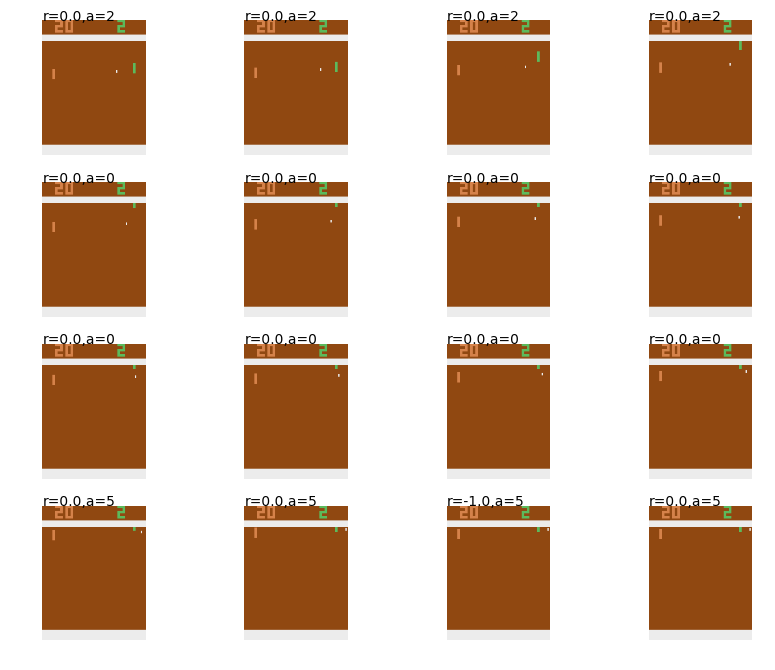

In [81]:
imgs = [elem['x_t1'] for elem in buf]
plt.figure(figsize=(10,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(imgs[i])
    plt.text(0,0,'r=' + str(buf[i]['r_t']) + ',a=' + str(buf[i]['a_t']))
    plt.axis('off')

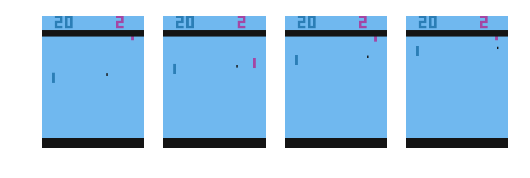

In [82]:
for i in range(phi_t.shape[0]):
    plt.subplot(1,4,i+1)
    plt.imshow(phi_t[i])
    plt.axis('off')

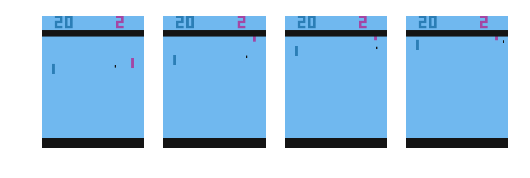

In [83]:
for i in range(phi_t1.shape[0]):
    plt.subplot(1,4,i+1)
    plt.imshow(phi_t1[i])
    plt.axis('off')

In [85]:
experience[-1]

{'a_t': 5,
 'debug_t': [1404, 1408, 1412, 1416],
 'debug_t1': [1408, 1412, 1416, 1420],
 'is_done': True,
 'phi_t': array([[[[   0.,    0.,    0.],
          [   0.,    0.,    0.],
          [   0.,    0.,    0.],
          ..., 
          [ 144.,   72.,   17.],
          [ 144.,   72.,   17.],
          [ 144.,   72.,   17.]],
 
         [[ 144.,   72.,   17.],
          [ 144.,   72.,   17.],
          [ 144.,   72.,   17.],
          ..., 
          [ 144.,   72.,   17.],
          [ 144.,   72.,   17.],
          [ 144.,   72.,   17.]],
 
         [[ 144.,   72.,   17.],
          [ 144.,   72.,   17.],
          [ 144.,   72.,   17.],
          ..., 
          [ 144.,   72.,   17.],
          [ 144.,   72.,   17.],
          [ 144.,   72.,   17.]],
 
         ..., 
         [[ 236.,  236.,  236.],
          [ 236.,  236.,  236.],
          [ 236.,  236.,  236.],
          ..., 
          [ 236.,  236.,  236.],
          [ 236.,  236.,  236.],
          [ 236.,  236.,  236.]],
 
  

In [90]:
def _sample_from_experience(experience, batch_size, gamma):
    # sample from random experience from the buffer
    idxs = [i for i in range(0, len(experience))] # index into ring buffer
    np.random.shuffle(idxs)
    rand_transitions = \
        [ experience[idx] for idx in idxs[0:batch_size] ]
    phi_t1_minibatch = np.asarray(
        [ rand_transitions[i]["phi_t1"] for i in range(len(rand_transitions)) ], dtype="float32")
    r_minibatch = np.asarray(
        [ [rand_transitions[i]["r_t"]] for i in range(len(rand_transitions)) ], dtype="float32")
    is_done_minibatch = np.asarray(
        [ [1.0*rand_transitions[i]["is_done"]] for i in range(len(rand_transitions)) ], dtype="float32")
    # ok, construct Q(phi_t) and its corresponding mask
    phi_t_minibatch = np.asarray(
        [ rand_transitions[i]["phi_t"] for i in range(len(rand_transitions)) ], dtype="float32")
    mask_t_minibatch = np.zeros((phi_t_minibatch.shape[0], env.action_space.n), dtype="float32")
    for i in range(mask_t_minibatch.shape[0]):
        mask_t_minibatch[ i, rand_transitions[i]["a_t"] ] = 1.

    #print r_minibatch
    #print phi_t1_minibatch
    #print phi_t_minibatch
    #print mask_t_minibatch
    #print [ rand_transitions[i]["a_t"] for i in range(len(rand_transitions)) ]
    #print "----"
    #self.train_fn = theano.function([r, gamma, is_done, phi_t1, phi_t, phi_t_mask], loss, updates=updates, on_unused_input='warn')
    return r_minibatch, np.float32(gamma), is_done_minibatch, phi_t1_minibatch, phi_t_minibatch, mask_t_minibatch


In [93]:
r_minibatch, gamma, is_done_minibatch, phi_t1_minibatch, phi_t_minibatch, mask_t_minibatch = \
    _sample_from_experience(experience, 10, 0.95)

In [95]:
r_minibatch

array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.]], dtype=float32)

In [96]:
gamma

0.94999999